In [2]:
import cv2
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
from settings import CALIB_FILE_NAME

def calibrate(filename, silent = True):
    images_path = 'camera_cal'
    cam_x = 9
    cam_y = 6

    objp = np.zeros((cam_y*cam_x, 3), np.float32)
    objp[:, :2] = np.mgrid[0:cam_x, 0:cam_y].T.reshape(-1, 2)
    image_points = []
    obj_dot = []

    term_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


    for image_file in os.listdir(images_path):
        if image_file.endswith("jpg"):
          
            img = mpimg.imread(os.path.join(images_path, image_file))
            img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            found, corners = cv2.findChessboardCorners(img_gray, (cam_x, cam_y))
            if found:
       
                cv2.drawChessboardCorners(img, (cam_x, cam_y), corners, found)
                corners2 = cv2.cornerSubPix(img_gray, corners, (11, 11), (-1, -1), term_criteria)
                image_points.append(corners2)
                obj_dot.append(objp)
                if not silent:
                    plt.imshow(img)
                    plt.show()

    
    ret, matrix, distance, rvecs, tvecs = cv2.calibrateCamera(obj_dot, image_points, img_gray.shape[::-1], None, None)
    img_size  = img.shape
    calib_data = {'cam_matrix':matrix,
                  'dist_coeffs':distance,
                  'img_size':img_size}
    with open(filename, 'wb') as f:
        pickle.dump(calib_data, f)

    if not silent:
        for image_file in os.listdir(images_path):
            if image_file.endswith("jpg"):
              
                img = mpimg.imread(os.path.join(images_path, image_file))
                plt.imshow(cv2.undistort(img, matrix, distance))
                plt.show()

    return matrix, distance




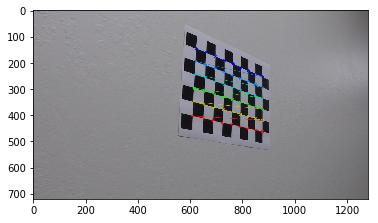

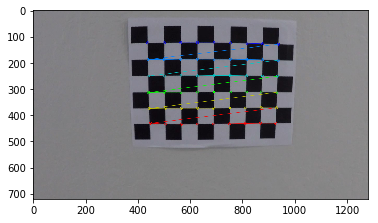

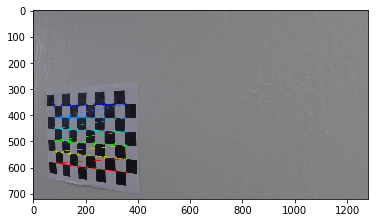

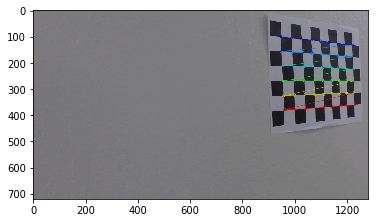

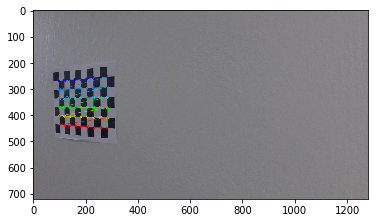

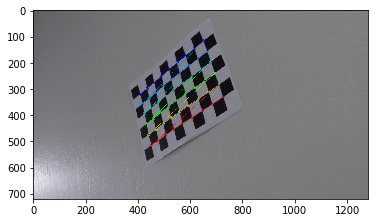

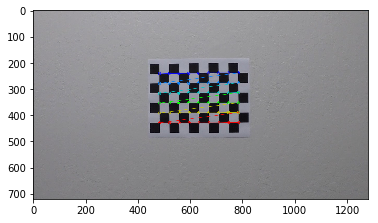

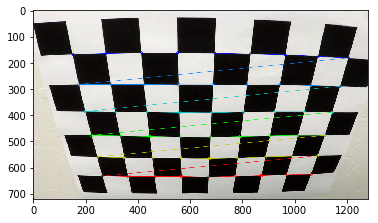

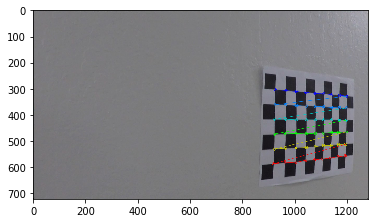

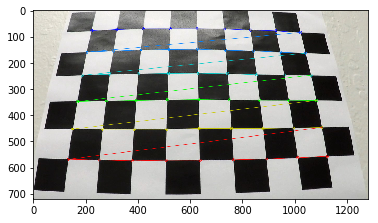

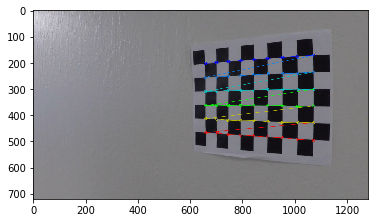

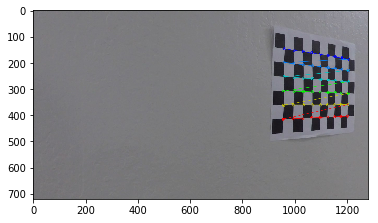

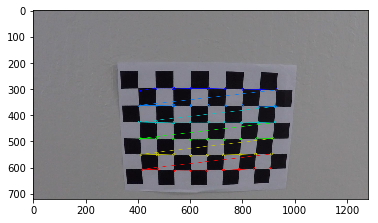

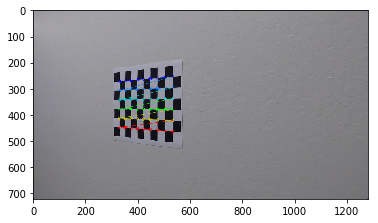

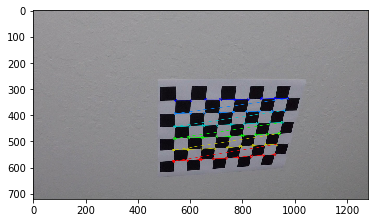

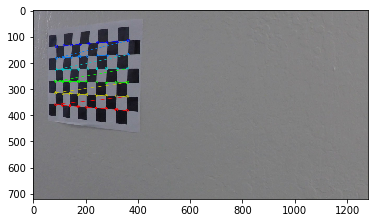

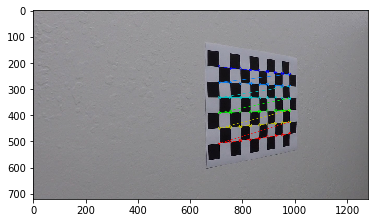

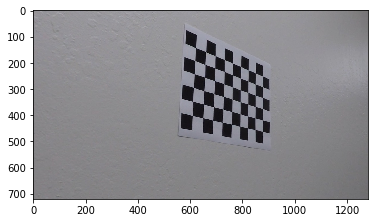

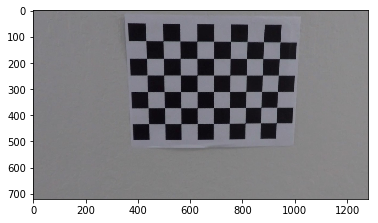

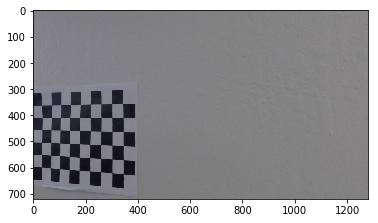

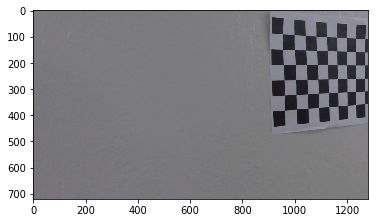

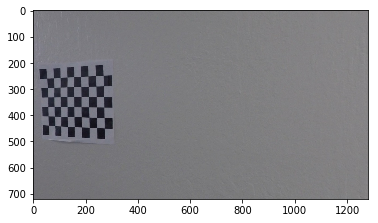

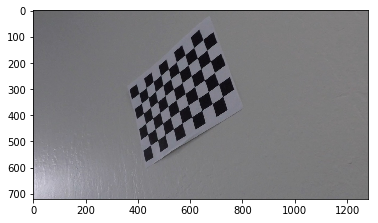

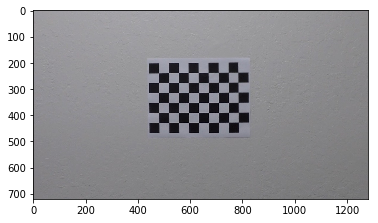

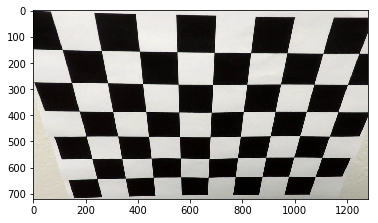

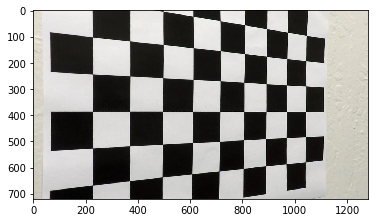

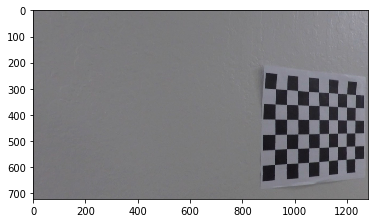

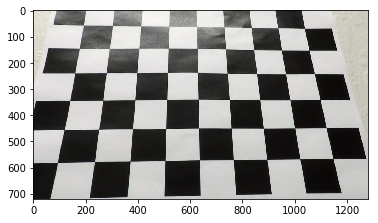

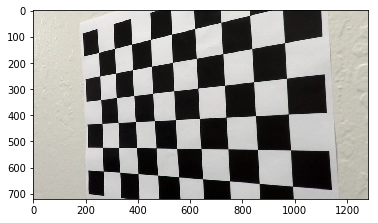

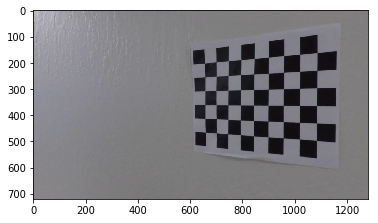

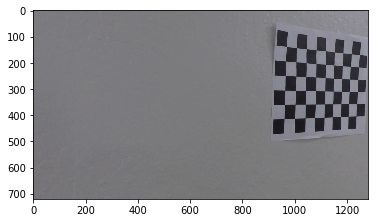

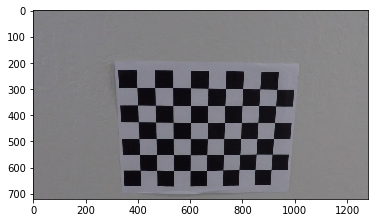

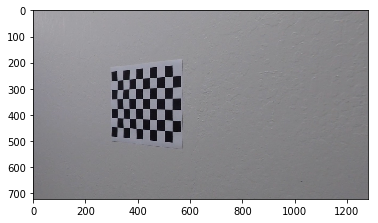

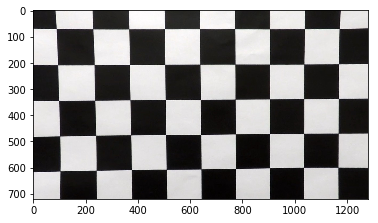

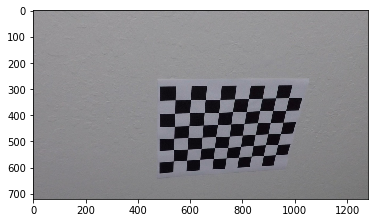

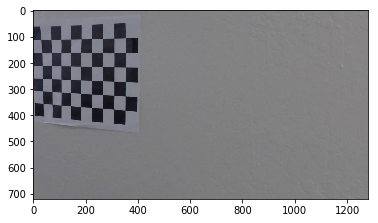

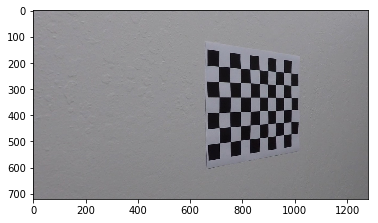

In [3]:
matrix, distance=calibrate(CALIB_FILE_NAME, False)

[[   0.  905.]
 [  57.  905.]
 [ 277.  685.]
 [   0.  685.]]
[[ 200.    0.]
 [ 900.    0.]
 [ 900.  700.]
 [ 200.  700.]]
(189.1891891891892, 24)


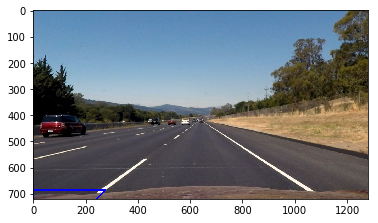

In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as pimg
import settings
import numpy as np
import cv2
import pickle

straight_images = ["test_images/straight_lines1.jpg", "test_images/straight_lines2.jpg"]
roi_points = np.array([[0, settings.ORIGINAL_SIZE[1]-50],[settings.ORIGINAL_SIZE[0],settings.ORIGINAL_SIZE[1]-50],
       [settings.ORIGINAL_SIZE[0]//2,settings.ORIGINAL_SIZE[1]//2+50]], dtype=np.int32)
roi = np.zeros((settings.ORIGINAL_SIZE[1], settings.ORIGINAL_SIZE[0]), dtype=np.uint8)
cv2.fillPoly(roi, [roi_points], 1)

with open(settings.CALIB_FILE_NAME, 'rb') as f:
    calib_data = pickle.load(f)
    cam_matrix = calib_data["cam_matrix"]
    dist_coeffs = calib_data["dist_coeffs"]

Lhs = np.zeros((2,2), dtype= np.float32)
Rhs = np.zeros((2,1), dtype= np.float32)

for img_path in straight_images:
    img = pimg.imread(img_path)
    img = cv2.undistort(img, cam_matrix, dist_coeffs)
    img_hsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    edges = cv2.Canny(img_hsl[:, :, 1], 200, 100)
    lines = cv2.HoughLinesP(edges*roi, 0.5, np.pi/180, 20, None, 180, 120)
    
            

def on_line(p1, p2, ycoord):
    return [p1[0]+ (p2[0]-p1[0])/float(p2[1]-p1[1])*(ycoord-p1[1]), ycoord]



src = np.float32(
		[[200, 720],
		[1100, 720],
		[595, 450],
		[685, 450]])
dst = np.float32(
		[[300, 720],
		[980, 720],
		[300, 0],
		[980, 0]])
print(src_points)
print(dst_points)



#for trapzoid
cv2.polylines(img, [src_points.astype(np.int32)],True, (0,0,255), thickness=5)

#find the projection matrix
M = cv2.getPerspectiveTransform(src_points, dst_points)

pix_per_meter_x = 700/3.7
Lh = np.linalg.inv(np.matmul(M, cam_matrix))
pix_per_meter_y = 720/30
print(pix_per_meter_x, pix_per_meter_y)

plt.imshow(img)
plt.show()

perspective_data = {'perspective_transform':M,
              'pixels_per_meter':(pix_per_meter_x, pix_per_meter_y),
              'orig_points':src_points}
with open(settings.PERSPECTIVE_FILE_NAME, 'wb') as f:
    pickle.dump(perspective_data, f)


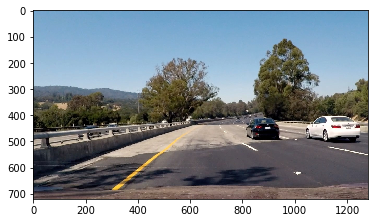

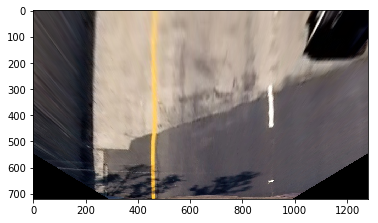

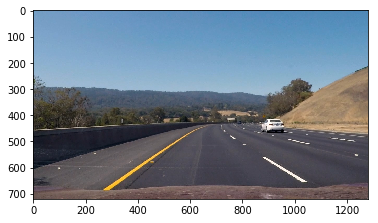

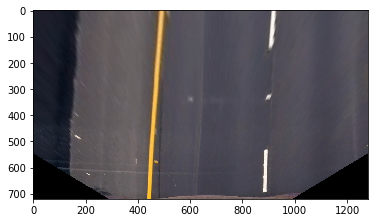

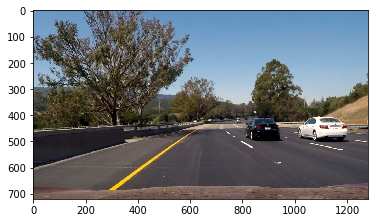

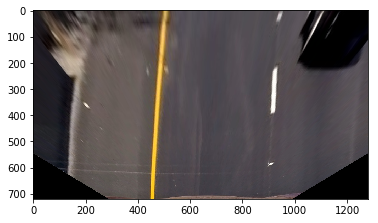

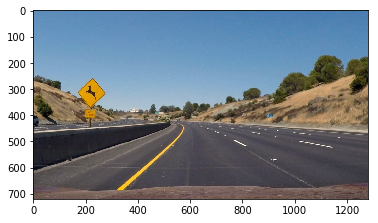

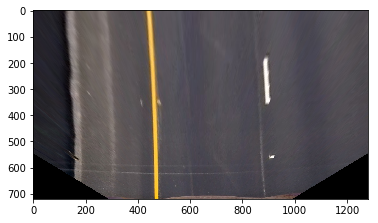

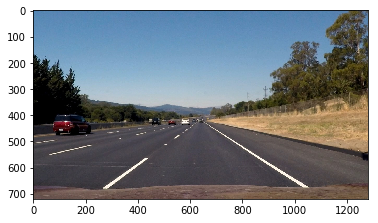

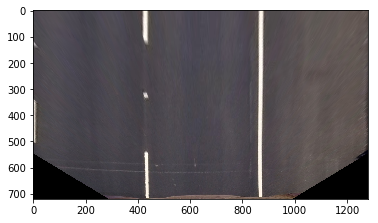

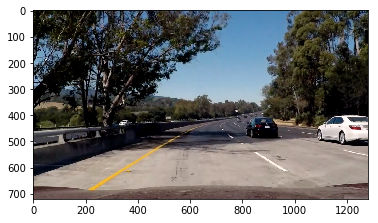

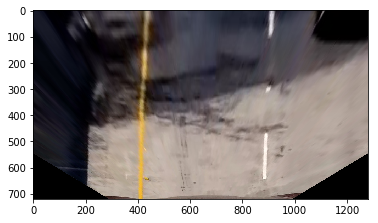

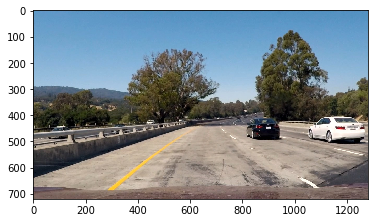

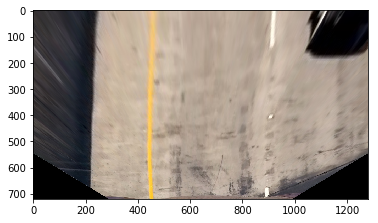

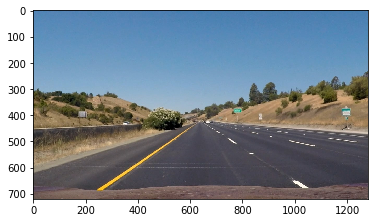

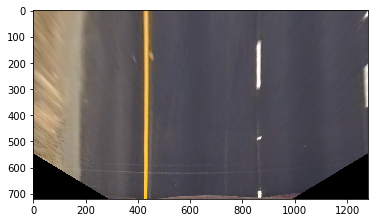

In [5]:
test_path='test_images'
for image_file in os.listdir(test_path):
        if image_file.endswith("jpg"):
            img = mpimg.imread(os.path.join(test_path, image_file))
            img = cv2.undistort(img, cam_matrix, dist_coeffs)
            plt.imshow(img)
            plt.show()
            img = cv2.warpPerspective(img, M, settings.ORIGINAL_SIZE)
            plt.imshow(img)
            plt.show()